<a href="https://colab.research.google.com/github/Mitchell-Odili/Walmart-store-sales-forecast/blob/main/walmart_store_sales_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('walmart-store-sales-forecasting')
jovian.set_colab_id('1geoDCN1KCIgnk2ZFlQolID9Rpb4nK77s')

# Walmart Store Sales Forecasting

Use historical markdown data to predict store sales

![](https://techcrunch.com/wp-content/uploads/2019/04/corp-site-homepage-banner-1.jpg?w=730&crop=1)

[Walmart Inc.](https://www.walmart.com/) is an American multinational retail corporation that operates a chain of hypermarkets, discount department stores, and grocery stores from the United States, headquartered in Bentonville,

## Introduction

One challenge of modeling retail data is the need to make decisions based on limited history. If Christmas comes but once a year, so does the chance to see how strategic decisions impacted the bottom line.

In this Jupyter notebook, we are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains many departments, and we must project the sales for each department in each store. To add to the challenge, selected holiday markdown events are included in the dataset. These markdowns are known to affect sales, but it is challenging to predict which departments are affected and the extent of the impact.



Let's install and import some required libraries before we begin

In [ ]:
!pip install numpy seaborn pandas matplotlib --q

In [ ]:
!pip install jovian opendatasets xgboost graphviz lightgbm scikit-learn xgboost lightgbm --upgrade --quiet

     |████████████████████████████████| 173.6 MB 7.3 kB/s 
     |████████████████████████████████| 46 kB 2.1 MB/s 
     |████████████████████████████████| 2.0 MB 43.2 MB/s 


In [ ]:
import os

## Problem Statement

The dataset we are given [Walmart Store Sales Forecasting](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data) consists historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and you are tasked with predicting the department-wide sales for each store.

In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

View and download the dataset here https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data

## Downloading the Data

We can download the dataset from Kaggle directly within the Jupyter notebook using the `opendatasets` library. Make sure to [accept the competition rules](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/rules) before executing the following cell.

In [ ]:
import opendatasets as od
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
od.download('https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data')

100%|██████████| 2.70M/2.70M [00:00<00:00, 136MB/s]


Extracting archive ./walmart-recruiting-store-sales-forecasting/walmart-recruiting-store-sales-forecasting.zip to ./walmart-recruiting-store-sales-forecasting


In [ ]:
os.listdir('walmart-recruiting-store-sales-forecasting')

['sampleSubmission.csv.zip',
 'train.csv.zip',
 'features.csv.zip',
 'test.csv.zip',
 'stores.csv']

The files `features.zip` ,`sample_Submission.csv.zip`, `test.csv.zip`, and `train.csv.zip` have been downloaded and are all in zip format. Let's unzip them using the [`zipfile`](https://docs.python.org/3/library/zipfile.html) module. `stores.csv` is already in csv format

In [ ]:
from zipfile import ZipFile

In [ ]:
with ZipFile('walmart-recruiting-store-sales-forecasting/features.csv.zip') as f:
    f.extractall(path = 'features')

In [ ]:
with ZipFile('walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip') as f:
    f.extractall(path = 'sample-submission')

In [ ]:
with ZipFile('walmart-recruiting-store-sales-forecasting/test.csv.zip') as f:
    f.extractall(path = 'test')

In [ ]:
with ZipFile('walmart-recruiting-store-sales-forecasting/train.csv.zip') as f:
    f.extractall(path = 'train')

The dataset is extracted to the folder `features`, `sample-submission`, `test` and `train`. Let's view the contents of the folder using the os module.

In [ ]:
os.listdir('features'), os.listdir('sample-submission'), os.listdir('test'),os.listdir('train')

(['features.csv'], ['sampleSubmission.csv'], ['test.csv'], ['train.csv'])

Let's load the data into Pandas dataframes.

In [ ]:
%%time
train_df = pd.read_csv('train/train.csv')
features_df = pd.read_csv('features/features.csv')
sample_submission_df = pd.read_csv('sample-submission/sampleSubmission.csv')
test_df = pd.read_csv('test/test.csv')
stores_df = pd.read_csv('walmart-recruiting-store-sales-forecasting/stores.csv')

CPU times: user 280 ms, sys: 48.7 ms, total: 329 ms
Wall time: 327 ms


In [ ]:
train_df

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


In [ ]:
features_df

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False


In [ ]:
sample_submission_df

,Id,Weekly_Sales
0,1_1_2012-11-02,0
1,1_1_2012-11-09,0
2,1_1_2012-11-16,0
3,1_1_2012-11-23,0
4,1_1_2012-11-30,0
...,...,...
115059,45_98_2013-06-28,0
115060,45_98_2013-07-05,0
115061,45_98_2013-07-12,0
115062,45_98_2013-07-19,0


In [ ]:
test_df

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False
...,...,...,...,...
115059,45,98,2013-06-28,False
115060,45,98,2013-07-05,False
115061,45,98,2013-07-12,False
115062,45,98,2013-07-19,False


In [ ]:
stores_df

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875
5,6,A,202505
6,7,B,70713
7,8,A,155078
8,9,B,125833
9,10,B,126512


Let's merge the information from `stores_df` & `features_df` into `train_df` and `test_df`.

In [ ]:
merged_df = train_df.merge(stores_df, how = 'left', on = 'Store')
merged_test_df = test_df.merge(stores_df, how = 'left', on = 'Store')

In [ ]:
merged_df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,False,A,151315
1,1,1,2010-02-12,46039.49,True,A,151315
2,1,1,2010-02-19,41595.55,False,A,151315
3,1,1,2010-02-26,19403.54,False,A,151315
4,1,1,2010-03-05,21827.90,False,A,151315
...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,B,118221
421566,45,98,2012-10-05,628.10,False,B,118221
421567,45,98,2012-10-12,1061.02,False,B,118221
421568,45,98,2012-10-19,760.01,False,B,118221


In [ ]:
merged_test_df

,Store,Dept,Date,IsHoliday,Type,Size
0,1,1,2012-11-02,False,A,151315
1,1,1,2012-11-09,False,A,151315
2,1,1,2012-11-16,False,A,151315
3,1,1,2012-11-23,True,A,151315
4,1,1,2012-11-30,False,A,151315
...,...,...,...,...,...,...
115059,45,98,2013-06-28,False,B,118221
115060,45,98,2013-07-05,False,B,118221
115061,45,98,2013-07-12,False,B,118221
115062,45,98,2013-07-19,False,B,118221


In [ ]:
features_df.Date.value_counts()

2011-05-27    45
2010-08-13    45
2010-08-27    45
2011-12-16    45
2010-09-24    45
              ..
2010-03-26    45
2010-11-05    45
2010-09-03    45
2013-01-04    45
2011-06-17    45
Name: Date, Length: 182, dtype: int64

In [ ]:
merge_df = merged_df.merge(features_df, how = 'inner', on = ['Store', 'Date', 'IsHoliday'])
merge_test_df = merged_test_df.merge(features_df, how = 'left', on = ['Store', 'Date', 'IsHoliday'])

In [ ]:
merge_df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
3,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
4,1,5,2010-02-05,32229.38,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,False,B,118221,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667
421566,45,94,2012-10-26,5203.31,False,B,118221,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667
421567,45,95,2012-10-26,56017.47,False,B,118221,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667
421568,45,97,2012-10-26,6817.48,False,B,118221,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667


In [ ]:
merge_test_df

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573
1,1,1,2012-11-09,False,A,151315,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573
2,1,1,2012-11-16,False,A,151315,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573
3,1,1,2012-11-23,True,A,151315,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573
4,1,1,2012-11-30,False,A,151315,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,98,2013-06-28,False,B,118221,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN
115060,45,98,2013-07-05,False,B,118221,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN
115061,45,98,2013-07-12,False,B,118221,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN
115062,45,98,2013-07-19,False,B,118221,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN


Let's save our work before continuing.

In [ ]:
jovian.commit('Walmart-Store-Sales-Forecasting')

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/mitchell-odili/walmart-store-sales-forecasting


'https://jovian.ai/mitchell-odili/walmart-store-sales-forecasting'

## Preprocessing and Feature Engineering

Let's take a look at the available columns, and figure out if we can create new columns or apply any useful transformations.

In [ ]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   MarkDown1     150681 non-null  float64
 10  MarkDown2     111248 non-null  float64
 11  MarkDown3     137091 non-null  float64
 12  MarkDown4     134967 non-null  float64
 13  MarkDown5     151432 non-null  float64
 14  CPI           421570 non-null  float64
 15  Unemployment  421570 non-null  float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB


### Date

First, let's convert `Date` to a `datecolumn` and extract different parts of the date.

In [ ]:
def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.isocalendar().week
    df['DayOfWeek'] = df.Date.dt.dayofweek

In [ ]:
split_date(merge_df)
split_date(merge_test_df)

In [ ]:
merge_df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Day,WeekOfYear,DayOfWeek
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2010,2,5,5,4
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2010,2,5,5,4
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2010,2,5,5,4
3,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2010,2,5,5,4
4,1,5,2010-02-05,32229.38,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2010,2,5,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,False,B,118221,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2012,10,26,43,4
421566,45,94,2012-10-26,5203.31,False,B,118221,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2012,10,26,43,4
421567,45,95,2012-10-26,56017.47,False,B,118221,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2012,10,26,43,4
421568,45,97,2012-10-26,6817.48,False,B,118221,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2012,10,26,43,4


In [ ]:
merge_df.DayOfWeek.value_counts()

4    421570
Name: DayOfWeek, dtype: int64

In [ ]:
merge_test_df

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Day,WeekOfYear,DayOfWeek
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,2012,11,2,44,4
1,1,1,2012-11-09,False,A,151315,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,2012,11,9,45,4
2,1,1,2012-11-16,False,A,151315,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,2012,11,16,46,4
3,1,1,2012-11-23,True,A,151315,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,2012,11,23,47,4
4,1,1,2012-11-30,False,A,151315,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573,2012,11,30,48,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,98,2013-06-28,False,B,118221,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,2013,6,28,26,4
115060,45,98,2013-07-05,False,B,118221,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,2013,7,5,27,4
115061,45,98,2013-07-12,False,B,118221,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,2013,7,12,28,4
115062,45,98,2013-07-19,False,B,118221,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,2013,7,19,29,4


### Descriptive Statistics and Data Visualizations

Let's look at Weekly Sales

In [ ]:
Weekly_sales = merge_df.groupby(['Year', 'WeekOfYear']).agg({'Weekly_Sales': ['mean', 'median']})
Weekly_sales

Weekly_Sales          
                         mean    median
Year WeekOfYear                        
2010 5           16836.121997  7904.690
     6           16352.056032  8365.095
     7           16216.658979  8411.250
     8           14899.549688  7235.800
     9           15921.015727  7717.975
...                       ...       ...
2012 39          14765.327279  6957.120
     40          15983.413747  7486.845
     41          15427.596739  7324.960
     42          15295.732397  7374.700
     43          15391.725681  7547.230

[143 rows x 2 columns]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


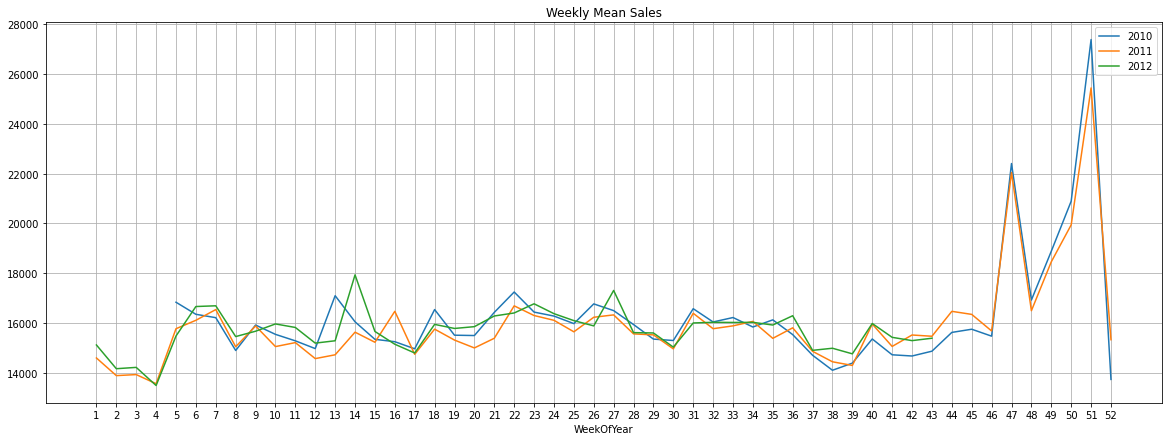

In [ ]:
Weekly_sales_2010 = merge_df.loc[merge_df['Year'] == 2010].groupby(['WeekOfYear']).agg({'Weekly_Sales': ['mean', 'median']})
Weekly_sales_2011 = merge_df.loc[merge_df['Year'] == 2011].groupby(['WeekOfYear']).agg({'Weekly_Sales': ['mean', 'median']})
Weekly_sales_2012 = merge_df.loc[merge_df['Year'] == 2012].groupby(['WeekOfYear']).agg({'Weekly_Sales': ['mean', 'median']})

plt.figure(figsize = (20, 7))
sns.lineplot(Weekly_sales_2010['Weekly_Sales']['mean'].index, Weekly_sales_2010['Weekly_Sales']['mean'].values)
sns.lineplot(Weekly_sales_2011['Weekly_Sales']['mean'].index, Weekly_sales_2011['Weekly_Sales']['mean'].values)
sns.lineplot(Weekly_sales_2012['Weekly_Sales']['mean'].index, Weekly_sales_2012['Weekly_Sales']['mean'].values)

plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'])
plt.title("Weekly Mean Sales")
plt.show();

Weekly sales average about 16000 all year round while peaking at 22000 around 
thanksgiving and hitting all time highs of 28000 at Christmas

### Training, Validation and Test Sets

While working with chronological data, it's often a good idea to separate the training, validation and test sets with time, so that the model is trained on data from the past and evaluated on data from the future.

We'll use the data till 2011 for the training set, data from 2012 for the validation set and the test set is given through to 2013

In [ ]:
merge_df['Year'].value_counts()

2011    153453
2010    140679
2012    127438
Name: Year, dtype: int64

In [ ]:
merge_train_df = merge_df[merge_df['Year'] < 2012]
merge_val_df = merge_df[merge_df['Year'] == 2012]

In [ ]:
print('merge_train_df.shape:', merge_train_df.shape)
print('merge_val_df.shape:', merge_val_df.shape)

merge_train_df.shape: (294132, 21)
merge_val_df.shape: (127438, 21)


### Input and Target Columns

Let's select the columns that we'll use for training.

In [ ]:
merge_df.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Type', 'Size',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Year', 'Month', 'Day',
       'WeekOfYear', 'DayOfWeek'],
      dtype='object')

In [ ]:
merge_test_df.columns

Index(['Store', 'Dept', 'Date', 'IsHoliday', 'Type', 'Size', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Year', 'Month', 'Day',
       'WeekOfYear', 'DayOfWeek'],
      dtype='object')

In [ ]:
input_cols = ['Store', 'Dept', 'IsHoliday', 'Type', 'Size', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Year', 'Month', 'Day',
       'WeekOfYear']
target_cols = 'Weekly_Sales'

In [ ]:
inputs = merge_df[input_cols].copy()
targets = merge_df[target_cols].copy()

train_inputs = merge_train_df[input_cols].copy()
train_targets = merge_train_df[target_cols].copy()

val_inputs = merge_val_df[input_cols].copy()
val_targets = merge_val_df[target_cols].copy()

In [ ]:
test_inputs = merge_test_df[input_cols].copy()

Let's also identify numeric and categorical columns. Note that we can treat binary categorical columns (0/1) as numeric columns.

In [ ]:
inputs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   IsHoliday     421570 non-null  bool   
 3   Type          421570 non-null  object 
 4   Size          421570 non-null  int64  
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Year          421570 non-null  int64  
 15  Month         421570 non-null  int64  
 16  Day           421570 non-null  int64  
 17  WeekOfYear    421570 non-null  UInt32 
dtypes: U

In [ ]:
numeric_cols =  inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = inputs.select_dtypes(['object', 'bool']).columns.tolist()

In [ ]:
numeric_cols

['Store',
 'Dept',
 'Size',
 'Temperature',
 'Fuel_Price',
 'MarkDown1',
 'MarkDown2',
 'MarkDown3',
 'MarkDown4',
 'MarkDown5',
 'CPI',
 'Unemployment',
 'Year',
 'Month',
 'Day',
 'WeekOfYear']

In [ ]:
categorical_cols

['IsHoliday', 'Type']

### Impute missing numerical data

In [ ]:
inputs[numeric_cols].isna().sum()

Store                0
Dept                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Year                 0
Month                0
Day                  0
WeekOfYear           0
dtype: int64

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.NaN, strategy = 'mean')

In [ ]:
imputer.fit(inputs[numeric_cols])

SimpleImputer()

In [ ]:
inputs[numeric_cols] = imputer.transform(inputs[numeric_cols])
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

In [ ]:
inputs[numeric_cols].isna().sum()

Store           0
Dept            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Year            0
Month           0
Day             0
WeekOfYear      0
dtype: int64

In [ ]:
train_inputs[numeric_cols].isna().sum()

Store           0
Dept            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Year            0
Month           0
Day             0
WeekOfYear      0
dtype: int64

In [ ]:
val_inputs[numeric_cols].isna().sum()

Store           0
Dept            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Year            0
Month           0
Day             0
WeekOfYear      0
dtype: int64

In [ ]:
test_inputs[numeric_cols].isna().sum()

Store           0
Dept            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Year            0
Month           0
Day             0
WeekOfYear      0
dtype: int64

### Scale Numeric Values

Let's scale numeric values to the 0 to 1 range.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler().fit(inputs[numeric_cols])

In [ ]:
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [ ]:
inputs

,Store,Dept,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Day,WeekOfYear
0,0.0,0.000000,False,A,0.630267,0.434149,0.050100,0.081742,0.034360,0.010367,0.050137,0.041462,0.840500,0.405118,0.0,0.090909,0.133333,0.078431
1,0.0,0.010204,False,A,0.630267,0.434149,0.050100,0.081742,0.034360,0.010367,0.050137,0.041462,0.840500,0.405118,0.0,0.090909,0.133333,0.078431
2,0.0,0.020408,False,A,0.630267,0.434149,0.050100,0.081742,0.034360,0.010367,0.050137,0.041462,0.840500,0.405118,0.0,0.090909,0.133333,0.078431
3,0.0,0.030612,False,A,0.630267,0.434149,0.050100,0.081742,0.034360,0.010367,0.050137,0.041462,0.840500,0.405118,0.0,0.090909,0.133333,0.078431
4,0.0,0.040816,False,A,0.630267,0.434149,0.050100,0.081742,0.034360,0.010367,0.050137,0.041462,0.840500,0.405118,0.0,0.090909,0.133333,0.078431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,1.0,0.938776,False,B,0.451136,0.595988,0.706413,0.045333,0.003091,0.000911,0.003138,0.006672,0.654796,0.458884,1.0,0.818182,0.833333,0.823529
421566,1.0,0.948980,False,B,0.451136,0.595988,0.706413,0.045333,0.003091,0.000911,0.003138,0.006672,0.654796,0.458884,1.0,0.818182,0.833333,0.823529
421567,1.0,0.959184,False,B,0.451136,0.595988,0.706413,0.045333,0.003091,0.000911,0.003138,0.006672,0.654796,0.458884,1.0,0.818182,0.833333,0.823529
421568,1.0,0.979592,False,B,0.451136,0.595988,0.706413,0.045333,0.003091,0.000911,0.003138,0.006672,0.654796,0.458884,1.0,0.818182,0.833333,0.823529


In [ ]:
train_inputs

,Store,Dept,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Day,WeekOfYear
0,0.0,0.000000,False,A,0.630267,0.434149,0.050100,0.081742,0.034360,0.010367,0.050137,0.041462,0.840500,0.405118,0.0,0.090909,0.133333,0.078431
1,0.0,0.010204,False,A,0.630267,0.434149,0.050100,0.081742,0.034360,0.010367,0.050137,0.041462,0.840500,0.405118,0.0,0.090909,0.133333,0.078431
2,0.0,0.020408,False,A,0.630267,0.434149,0.050100,0.081742,0.034360,0.010367,0.050137,0.041462,0.840500,0.405118,0.0,0.090909,0.133333,0.078431
3,0.0,0.030612,False,A,0.630267,0.434149,0.050100,0.081742,0.034360,0.010367,0.050137,0.041462,0.840500,0.405118,0.0,0.090909,0.133333,0.078431
4,0.0,0.040816,False,A,0.630267,0.434149,0.050100,0.081742,0.034360,0.010367,0.050137,0.041462,0.840500,0.405118,0.0,0.090909,0.133333,0.078431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418660,1.0,0.938776,True,B,0.451136,0.389922,0.459419,0.040657,0.421885,0.002235,0.005294,0.005673,0.622702,0.445083,0.5,1.000000,0.966667,1.000000
418661,1.0,0.948980,True,B,0.451136,0.389922,0.459419,0.040657,0.421885,0.002235,0.005294,0.005673,0.622702,0.445083,0.5,1.000000,0.966667,1.000000
418662,1.0,0.959184,True,B,0.451136,0.389922,0.459419,0.040657,0.421885,0.002235,0.005294,0.005673,0.622702,0.445083,0.5,1.000000,0.966667,1.000000
418663,1.0,0.979592,True,B,0.451136,0.389922,0.459419,0.040657,0.421885,0.002235,0.005294,0.005673,0.622702,0.445083,0.5,1.000000,0.966667,1.000000


In [ ]:
val_inputs

,Store,Dept,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Day,WeekOfYear
7169,0.0,0.000000,False,A,0.630267,0.499706,0.343186,0.070811,0.210706,0.001216,0.021488,0.077021,0.925683,0.332471,1.0,0.000000,0.166667,0.000000
7170,0.0,0.010204,False,A,0.630267,0.499706,0.343186,0.070811,0.210706,0.001216,0.021488,0.077021,0.925683,0.332471,1.0,0.000000,0.166667,0.000000
7171,0.0,0.020408,False,A,0.630267,0.499706,0.343186,0.070811,0.210706,0.001216,0.021488,0.077021,0.925683,0.332471,1.0,0.000000,0.166667,0.000000
7172,0.0,0.030612,False,A,0.630267,0.499706,0.343186,0.070811,0.210706,0.001216,0.021488,0.077021,0.925683,0.332471,1.0,0.000000,0.166667,0.000000
7173,0.0,0.040816,False,A,0.630267,0.499706,0.343186,0.070811,0.210706,0.001216,0.021488,0.077021,0.925683,0.332471,1.0,0.000000,0.166667,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,1.0,0.938776,False,B,0.451136,0.595988,0.706413,0.045333,0.003091,0.000911,0.003138,0.006672,0.654796,0.458884,1.0,0.818182,0.833333,0.823529
421566,1.0,0.948980,False,B,0.451136,0.595988,0.706413,0.045333,0.003091,0.000911,0.003138,0.006672,0.654796,0.458884,1.0,0.818182,0.833333,0.823529
421567,1.0,0.959184,False,B,0.451136,0.595988,0.706413,0.045333,0.003091,0.000911,0.003138,0.006672,0.654796,0.458884,1.0,0.818182,0.833333,0.823529
421568,1.0,0.979592,False,B,0.451136,0.595988,0.706413,0.045333,0.003091,0.000911,0.003138,0.006672,0.654796,0.458884,1.0,0.818182,0.833333,0.823529


In [ ]:
test_inputs

,Store,Dept,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Day,WeekOfYear
0,0.0,0.000000,False,A,0.630267,0.561448,0.457916,0.076328,0.051662,0.000564,0.053941,0.024010,0.962735,0.258194,1.0,0.909091,0.033333,0.843137
1,0.0,0.000000,False,A,0.630267,0.619374,0.421844,0.128838,0.034706,0.000490,0.068864,0.055534,0.962918,0.258194,1.0,0.909091,0.266667,0.862745
2,0.0,0.000000,False,A,0.630267,0.537965,0.390782,0.109378,0.005324,0.000938,0.016790,0.059765,0.963231,0.258194,1.0,0.909091,0.500000,0.882353
3,0.0,0.000000,True,A,0.630267,0.570352,0.370240,0.009965,0.002576,0.529010,0.003108,0.001552,0.963716,0.258194,1.0,0.909091,0.733333,0.901961
4,0.0,0.000000,False,A,0.630267,0.532290,0.368236,0.027748,0.034360,0.027301,0.002228,0.063027,0.964200,0.258194,1.0,0.909091,0.966667,0.921569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,1.0,0.989796,False,B,0.451136,0.764286,0.584669,0.054622,0.011841,0.000227,0.036306,0.027998,0.446165,0.391153,1.5,0.454545,0.900000,0.490196
115060,1.0,0.989796,False,B,0.451136,0.778474,0.572144,0.102545,0.024186,0.004319,0.085917,0.012730,0.446165,0.391153,1.5,0.545455,0.133333,0.509804
115061,1.0,0.989796,False,B,0.451136,0.796771,0.572144,0.042750,0.019975,0.000811,0.011036,0.018593,0.446165,0.391153,1.5,0.545455,0.366667,0.529412
115062,1.0,0.989796,False,B,0.451136,0.830724,0.633768,0.033405,0.012529,0.001647,0.005377,0.008528,0.446165,0.391153,1.5,0.545455,0.600000,0.549020


### Encode Categorical Columns

<img src="https://i.imgur.com/n8GuiOO.png" width="640">

Let's one-hot encode categorical columns.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names(categorical_cols))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
encoded_cols

['IsHoliday_False', 'IsHoliday_True', 'Type_A', 'Type_B', 'Type_C']

In [ ]:
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

Finally, let's extract out all the numeric data for training.

In [ ]:
X = inputs[numeric_cols + encoded_cols]
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [ ]:
X

,Store,Dept,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Day,WeekOfYear,IsHoliday_False,IsHoliday_True,Type_A,Type_B,Type_C
0,0.0,0.000000,0.630267,0.434149,0.050100,0.081742,0.034360,0.010367,0.050137,0.041462,0.840500,0.405118,0.0,0.090909,0.133333,0.078431,1.0,0.0,1.0,0.0,0.0
1,0.0,0.010204,0.630267,0.434149,0.050100,0.081742,0.034360,0.010367,0.050137,0.041462,0.840500,0.405118,0.0,0.090909,0.133333,0.078431,1.0,0.0,1.0,0.0,0.0
2,0.0,0.020408,0.630267,0.434149,0.050100,0.081742,0.034360,0.010367,0.050137,0.041462,0.840500,0.405118,0.0,0.090909,0.133333,0.078431,1.0,0.0,1.0,0.0,0.0
3,0.0,0.030612,0.630267,0.434149,0.050100,0.081742,0.034360,0.010367,0.050137,0.041462,0.840500,0.405118,0.0,0.090909,0.133333,0.078431,1.0,0.0,1.0,0.0,0.0
4,0.0,0.040816,0.630267,0.434149,0.050100,0.081742,0.034360,0.010367,0.050137,0.041462,0.840500,0.405118,0.0,0.090909,0.133333,0.078431,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,1.0,0.938776,0.451136,0.595988,0.706413,0.045333,0.003091,0.000911,0.003138,0.006672,0.654796,0.458884,1.0,0.818182,0.833333,0.823529,1.0,0.0,0.0,1.0,0.0
421566,1.0,0.948980,0.451136,0.595988,0.706413,0.045333,0.003091,0.000911,0.003138,0.006672,0.654796,0.458884,1.0,0.818182,0.833333,0.823529,1.0,0.0,0.0,1.0,0.0
421567,1.0,0.959184,0.451136,0.595988,0.706413,0.045333,0.003091,0.000911,0.003138,0.006672,0.654796,0.458884,1.0,0.818182,0.833333,0.823529,1.0,0.0,0.0,1.0,0.0
421568,1.0,0.979592,0.451136,0.595988,0.706413,0.045333,0.003091,0.000911,0.003138,0.006672,0.654796,0.458884,1.0,0.818182,0.833333,0.823529,1.0,0.0,0.0,1.0,0.0


In [ ]:
X_test

,Store,Dept,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Day,WeekOfYear,IsHoliday_False,IsHoliday_True,Type_A,Type_B,Type_C
0,0.0,0.000000,0.630267,0.561448,0.457916,0.076328,0.051662,0.000564,0.053941,0.024010,0.962735,0.258194,1.0,0.909091,0.033333,0.843137,1.0,0.0,1.0,0.0,0.0
1,0.0,0.000000,0.630267,0.619374,0.421844,0.128838,0.034706,0.000490,0.068864,0.055534,0.962918,0.258194,1.0,0.909091,0.266667,0.862745,1.0,0.0,1.0,0.0,0.0
2,0.0,0.000000,0.630267,0.537965,0.390782,0.109378,0.005324,0.000938,0.016790,0.059765,0.963231,0.258194,1.0,0.909091,0.500000,0.882353,1.0,0.0,1.0,0.0,0.0
3,0.0,0.000000,0.630267,0.570352,0.370240,0.009965,0.002576,0.529010,0.003108,0.001552,0.963716,0.258194,1.0,0.909091,0.733333,0.901961,0.0,1.0,1.0,0.0,0.0
4,0.0,0.000000,0.630267,0.532290,0.368236,0.027748,0.034360,0.027301,0.002228,0.063027,0.964200,0.258194,1.0,0.909091,0.966667,0.921569,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,1.0,0.989796,0.451136,0.764286,0.584669,0.054622,0.011841,0.000227,0.036306,0.027998,0.446165,0.391153,1.5,0.454545,0.900000,0.490196,1.0,0.0,0.0,1.0,0.0
115060,1.0,0.989796,0.451136,0.778474,0.572144,0.102545,0.024186,0.004319,0.085917,0.012730,0.446165,0.391153,1.5,0.545455,0.133333,0.509804,1.0,0.0,0.0,1.0,0.0
115061,1.0,0.989796,0.451136,0.796771,0.572144,0.042750,0.019975,0.000811,0.011036,0.018593,0.446165,0.391153,1.5,0.545455,0.366667,0.529412,1.0,0.0,0.0,1.0,0.0
115062,1.0,0.989796,0.451136,0.830724,0.633768,0.033405,0.012529,0.001647,0.005377,0.008528,0.446165,0.391153,1.5,0.545455,0.600000,0.549020,1.0,0.0,0.0,1.0,0.0


Let's save our work before continuing.

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/mitchell-odili/walmart-store-sales-forecasting


'https://jovian.ai/mitchell-odili/walmart-store-sales-forecasting'

# Training

We'll train the model using
1. Decision Trees
2. Random Forest 
3. XGBoost Regressor


## Training and Visualizing Decision Trees

A decision tree in general parlance represents a hierarchical series of binary decisions:

<img src="https://i.imgur.com/qSH4lqz.png" width="480">

A decision tree in machine learning works in exactly the same way, and except that we let the computer figure out the optimal structure & hierarchy of decisions, instead of coming up with criteria manually.

### Decision Tree Regressor

We can use `DecisionTreeRegressor` from `sklearn.tree` to train a decision tree.

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
model = DecisionTreeRegressor(random_state = 42)

In [ ]:
%%time
model.fit(X_train, train_targets)

CPU times: user 3.88 s, sys: 20.4 ms, total: 3.9 s
Wall time: 3.9 s


DecisionTreeRegressor(random_state=42)

An optimal decision tree has now been created using the training data.

### Prediction

We can now make predictions and evaluate the model using `model.predict`.

In [ ]:
preds = model.predict(X_train)

In [ ]:
preds

array([24924.5 , 50605.27, 13740.12, ..., 42084.36,  5569.82,   553.21])

#### Evaluation

Let's evaluate the decision tree using the `RMSE`.

In [ ]:
from sklearn.metrics import mean_squared_error

def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

In [ ]:
rmse(preds, train_targets)

7.391002160211172e-17

We can make predictions and compute accuracy in one step using model.score. Let's check the accuracy of its predictions.

In [ ]:
model.score(X_val, val_targets)

0.9146062479308111

The accuracy on the validation set is about 91%

### Visualization

We can visualize the decision tree _learned_ from the training data.

In [ ]:
from sklearn.tree import plot_tree, export_text

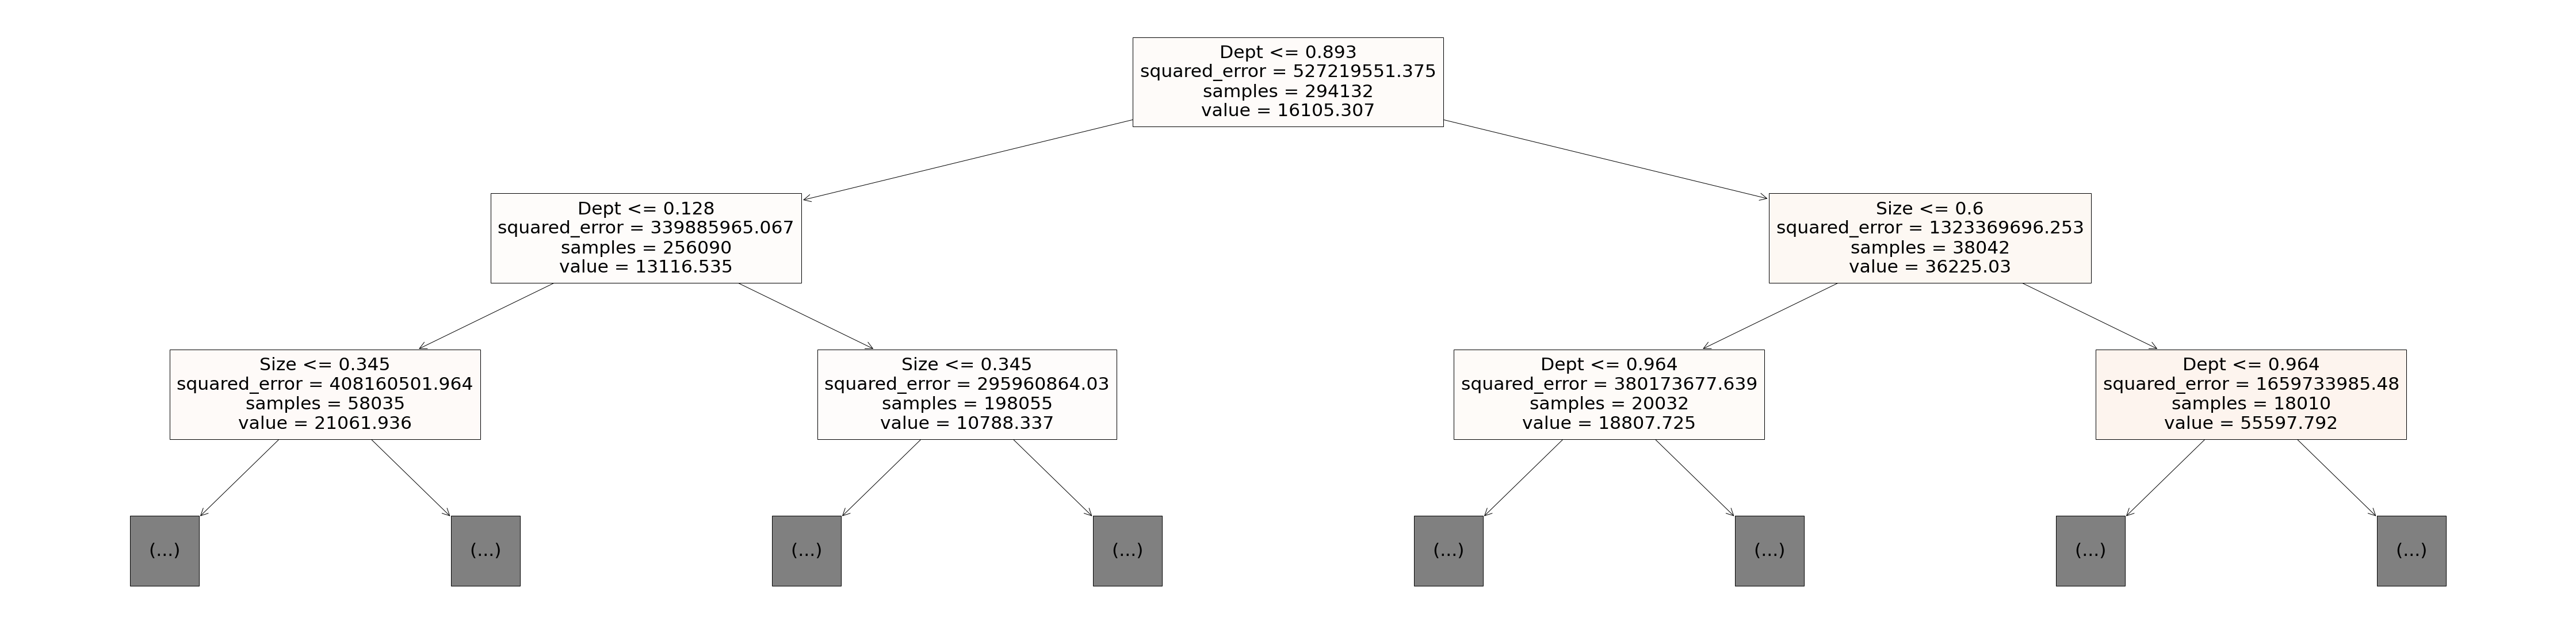

In [ ]:
plt.figure(figsize = (80,20))
plot_tree(model, feature_names = X_train.columns, max_depth =2, filled = True);

We can also display the tree as text, which can be easier to follow for deeper trees.

In [ ]:
tree_text = export_text(model, max_depth=10, feature_names=list(X_train.columns))
print(tree_text[:5000])

|--- Dept <= 0.89
|   |--- Dept <= 0.13
|   |   |--- Size <= 0.35
|   |   |   |--- Size <= 0.08
|   |   |   |   |--- Dept <= 0.02
|   |   |   |   |   |--- Dept <= 0.01
|   |   |   |   |   |   |--- Type_A <= 0.50
|   |   |   |   |   |   |   |--- WeekOfYear <= 0.75
|   |   |   |   |   |   |   |   |--- Unemployment <= 0.57
|   |   |   |   |   |   |   |   |   |--- Store <= 0.07
|   |   |   |   |   |   |   |   |   |   |--- WeekOfYear <= 0.32
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 12
|   |   |   |   |   |   |   |   |   |   |--- WeekOfYear >  0.32
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 12
|   |   |   |   |   |   |   |   |   |--- Store >  0.07
|   |   |   |   |   |   |   |   |   |   |--- Store <= 0.94
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 20
|   |   |   |   |   |   |   |   |   |   |--- Store >  0.94
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 17
|   |   | 

### Feature Importance

Based on the gini index computations, a decision tree assigns an "importance" value to each feature. These values can be used to interpret the results given by a decision tree.

In [ ]:
model.feature_importances_

array([4.81572159e-02, 6.20783714e-01, 1.86952074e-01, 9.48975303e-03,
       4.54680688e-03, 4.54418571e-04, 9.41993356e-04, 1.55687074e-03,
       9.51628842e-04, 4.22462058e-04, 3.13550760e-02, 1.21002987e-02,
       4.98346455e-04, 1.62479946e-03, 1.01615783e-02, 5.35508787e-02,
       5.81556120e-04, 3.97666602e-04, 4.90839355e-03, 1.02196119e-02,
       3.44857147e-04])

Let's turn this into a dataframe and visualize the most important features.

In [ ]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending = False)

In [ ]:
importance_df

,feature,importance
1,Dept,0.620784
2,Size,0.186952
15,WeekOfYear,0.053551
0,Store,0.048157
10,CPI,0.031355
11,Unemployment,0.012100
19,Type_B,0.010220
14,Day,0.010162
3,Temperature,0.009490
18,Type_A,0.004908


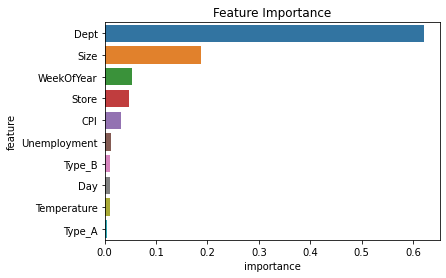

In [ ]:
plt.title('Feature Importance')
sns.barplot(data = importance_df.head(10), x = 'importance', y = 'feature');

#### Hyperparameter Tuning and Overfitting

In [ ]:
?DecisionTreeRegressor

These arguments are called hyperparameters because they must be configured manually (as opposed to the parameters within the model which are _learned_ from the data. We'll explore a couple of hyperparameters:

- `max_depth`
- `max_leaf_nodes`

In [ ]:
model = DecisionTreeRegressor(max_depth=3, random_state=42)

In [ ]:
model.fit(X_train, train_targets)

DecisionTreeRegressor(max_depth=3, random_state=42)

We can compute the accuracy of the model on the training and validation sets using `model.score`

In [ ]:
model.score(X_train, train_targets)

0.35923081026850967

In [ ]:
model.score(X_val, val_targets)

0.40753336168362375

That's very low accuracy for both the train and validation datasets. Let's experiment with different depths using a helper function.

In [ ]:
def max_depth_error(md):
    model = DecisionTreeRegressor(max_depth=md, random_state=42)
    model.fit(X_train, train_targets)
    train_err = 1 - model.score(X_train, train_targets)
    val_err = 1 - model.score(X_val, val_targets)
    return {'Max Depth': md, 'Training Error': train_err, 'Validation Error': val_err}

In [ ]:
%%time
errors_df = pd.DataFrame([max_depth_error(md) for md in range(1, 21)])

CPU times: user 34.3 s, sys: 52.2 ms, total: 34.3 s
Wall time: 34.1 s


In [ ]:
errors_df

,Max Depth,Training Error,Validation Error
0,1,0.885943,0.870054
1,2,0.772618,0.753216
2,3,0.640769,0.592467
3,4,0.591420,0.540841
4,5,0.470310,0.429867
5,6,0.308704,0.260237
6,7,0.245109,0.214428
7,8,0.208920,0.182965
8,9,0.170199,0.159441
9,10,0.131825,0.134382


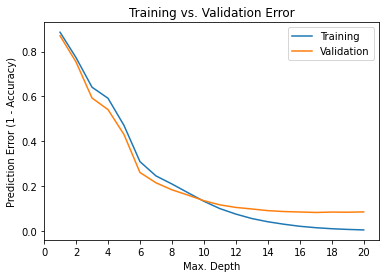

In [ ]:
plt.figure()
plt.plot(errors_df['Max Depth'], errors_df['Training Error'])
plt.plot(errors_df['Max Depth'], errors_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation']);

This is a common pattern you'll see with all machine learning algorithms:

<img src="https://i.imgur.com/EJCrSZw.png" width="480">




You'll often need to tune hyperparameters carefully to find the optimal fit. In the above case, it appears that a maximum depth of 10 results in the lowest validation error.

In [ ]:
model = DecisionTreeRegressor(max_depth=10, random_state=42).fit(X_train, train_targets)
model.score(X_val, val_targets)

0.8656183188084914

An improvement over a max depth of 3 however, still less than the default arguments which have a near 91% accuracy with the validation set

### `max_leaf_nodes`

Another way to control the size of complexity of a decision tree is to limit the number of leaf nodes. This allows branches of the tree to have varying depths. 

In [ ]:
model = DecisionTreeRegressor(max_leaf_nodes=128, random_state=42)

In [ ]:
model.fit(X_train, train_targets)

DecisionTreeRegressor(max_leaf_nodes=128, random_state=42)

In [ ]:
model.score(X_train, train_targets)

0.8387014854468948

In [ ]:
model.score(X_val, val_targets)

0.8391308176796993

Fair but less impressive than the default arguments

In [ ]:
model.tree_.max_depth

14

Notice that the model was able to achieve a greater depth of 14 for certain paths while keeping other paths shorter.

In [ ]:
model_text = export_text(model, feature_names=list(X_train.columns))
print(model_text[:3000])

|--- Dept <= 0.89
|   |--- Dept <= 0.13
|   |   |--- Size <= 0.35
|   |   |   |--- Size <= 0.08
|   |   |   |   |--- value: [5353.38]
|   |   |   |--- Size >  0.08
|   |   |   |   |--- value: [15437.41]
|   |   |--- Size >  0.35
|   |   |   |--- Dept <= 0.02
|   |   |   |   |--- Dept <= 0.01
|   |   |   |   |   |--- WeekOfYear <= 0.93
|   |   |   |   |   |   |--- value: [22511.08]
|   |   |   |   |   |--- WeekOfYear >  0.93
|   |   |   |   |   |   |--- value: [42578.01]
|   |   |   |   |--- Dept >  0.01
|   |   |   |   |   |--- CPI <= 0.05
|   |   |   |   |   |   |--- Store <= 0.44
|   |   |   |   |   |   |   |--- value: [87745.92]
|   |   |   |   |   |   |--- Store >  0.44
|   |   |   |   |   |   |   |--- value: [46690.63]
|   |   |   |   |   |--- CPI >  0.05
|   |   |   |   |   |   |--- Size <= 0.73
|   |   |   |   |   |   |   |--- Size <= 0.47
|   |   |   |   |   |   |   |   |--- value: [54016.64]
|   |   |   |   |   |   |   |--- Size >  0.47
|   |   |   |   |   |   |   |   |--- val

## Putting it Together and Making Predictions

Let's train a final model on the entire training set with default hyperparameters. 

In [ ]:
model = DecisionTreeRegressor(random_state = 42)

In [ ]:
X

,Store,Dept,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Day,WeekOfYear,IsHoliday_False,IsHoliday_True,Type_A,Type_B,Type_C
0,0.0,0.000000,0.630267,0.434149,0.050100,0.081742,0.034360,0.010367,0.050137,0.041462,0.840500,0.405118,0.0,0.090909,0.133333,0.078431,1.0,0.0,1.0,0.0,0.0
1,0.0,0.010204,0.630267,0.434149,0.050100,0.081742,0.034360,0.010367,0.050137,0.041462,0.840500,0.405118,0.0,0.090909,0.133333,0.078431,1.0,0.0,1.0,0.0,0.0
2,0.0,0.020408,0.630267,0.434149,0.050100,0.081742,0.034360,0.010367,0.050137,0.041462,0.840500,0.405118,0.0,0.090909,0.133333,0.078431,1.0,0.0,1.0,0.0,0.0
3,0.0,0.030612,0.630267,0.434149,0.050100,0.081742,0.034360,0.010367,0.050137,0.041462,0.840500,0.405118,0.0,0.090909,0.133333,0.078431,1.0,0.0,1.0,0.0,0.0
4,0.0,0.040816,0.630267,0.434149,0.050100,0.081742,0.034360,0.010367,0.050137,0.041462,0.840500,0.405118,0.0,0.090909,0.133333,0.078431,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,1.0,0.938776,0.451136,0.595988,0.706413,0.045333,0.003091,0.000911,0.003138,0.006672,0.654796,0.458884,1.0,0.818182,0.833333,0.823529,1.0,0.0,0.0,1.0,0.0
421566,1.0,0.948980,0.451136,0.595988,0.706413,0.045333,0.003091,0.000911,0.003138,0.006672,0.654796,0.458884,1.0,0.818182,0.833333,0.823529,1.0,0.0,0.0,1.0,0.0
421567,1.0,0.959184,0.451136,0.595988,0.706413,0.045333,0.003091,0.000911,0.003138,0.006672,0.654796,0.458884,1.0,0.818182,0.833333,0.823529,1.0,0.0,0.0,1.0,0.0
421568,1.0,0.979592,0.451136,0.595988,0.706413,0.045333,0.003091,0.000911,0.003138,0.006672,0.654796,0.458884,1.0,0.818182,0.833333,0.823529,1.0,0.0,0.0,1.0,0.0


In [ ]:
%%time
model.fit(X, targets)

CPU times: user 6.83 s, sys: 49.2 ms, total: 6.88 s
Wall time: 6.83 s


DecisionTreeRegressor(random_state=42)

Now that the model is trained, we can make predictions on the test set.

In [ ]:
test_preds = model.predict(X_test)

In [ ]:
test_preds

array([27390.81, 32494.43, 32494.43, ...,    99.6 ,    99.6 ,   124.68])

Let's add the predictions into `sample_submission_df`.

In [ ]:
sample_submission_df['Weekly_Sales'] = test_preds

In [ ]:
sample_submission_df

,Id,Weekly_Sales
0,1_1_2012-11-02,27390.81
1,1_1_2012-11-09,32494.43
2,1_1_2012-11-16,32494.43
3,1_1_2012-11-23,32494.43
4,1_1_2012-11-30,24531.27
...,...,...
115059,45_98_2013-06-28,140.25
115060,45_98_2013-07-05,169.18
115061,45_98_2013-07-12,99.60
115062,45_98_2013-07-19,99.60


We can now save the predictions as a CSV file.

In [ ]:
sample_submission_df.to_csv('DTRsampleSubmission.csv', index = None)

In [ ]:
from IPython.display import FileLink

In [ ]:
FileLink('DTRsampleSubmission.csv')

/content/DTRsampleSubmission.csv

The computed error of 4742.71434 places us in the 60th percentile in the Kaggle Public Leaderboard. (position 410/688). Let's explore Random Forest and Xgbost to hopefully improve the accuracy of our predictions and improve our ranking

## Training a Random Forest

While tuning the hyperparameters of a single decision tree may lead to some improvements, a much more effective strategy is to combine the results of several decision trees trained with slightly different parameters. This is called a random forest model. 

The key idea here is that each decision tree in the forest will make different kinds of errors, and upon averaging, many of their errors will cancel out. This idea is also commonly known as the "wisdom of the crowd":

<img src="https://i.imgur.com/4Dg0XK4.png" width="480">

A random forest works by averaging/combining the results of several decision trees:

<img src="https://1.bp.blogspot.com/-Ax59WK4DE8w/YK6o9bt_9jI/AAAAAAAAEQA/9KbBf9cdL6kOFkJnU39aUn4m8ydThPenwCLcBGAsYHQ/s0/Random%2BForest%2B03.gif" width="640">


We'll use the `RandomForestRegressor` class from `sklearn.ensemble`.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
model = RandomForestRegressor(n_jobs = -1, random_state=42)

`n_jobs` allows the random forest to use mutiple parallel workers to train decision trees, and `random_state=42` ensures that the we get the same results for each execution (fix the randomness).

In [ ]:
%%time
model.fit(X_train, train_targets)

CPU times: user 6min 4s, sys: 2.52 s, total: 6min 6s
Wall time: 3min 9s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [ ]:
model.score(X_train, train_targets)

0.9966456662495163

In [ ]:
model.score(X_val, val_targets)

0.9504815664085803

The training accuracy is almost 100%, but this time the validation accuracy is much better. In fact, it is better than the best single decision tree we had trained so far. Do you see the power of random forests?

This general technique of combining the results of many models is called "ensembling", it works because most errors of individual models cancel out on averaging. Here's what it looks like visually:

<img src="https://i.imgur.com/qJo8D8b.png" width="640">


We can can access individual decision trees using `model.estimators_`

In [ ]:
model.estimators_[0]

DecisionTreeRegressor(max_features='auto', random_state=1608637542)

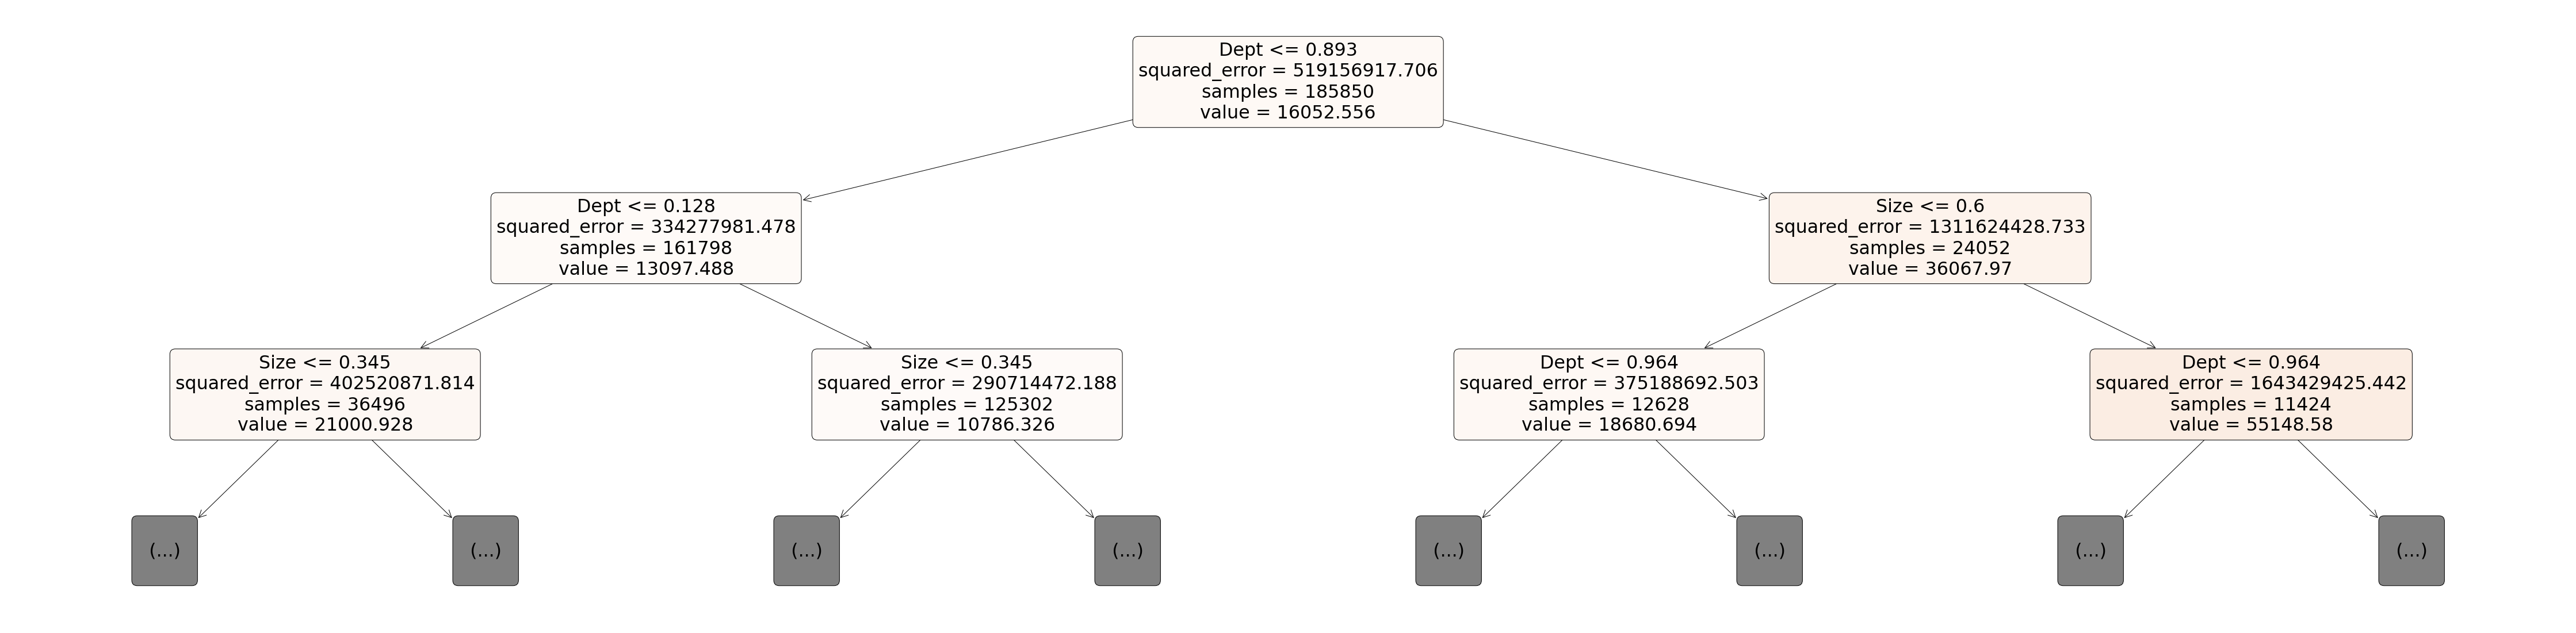

In [ ]:
plt.figure(figsize=(80,20))
plot_tree(model.estimators_[0], max_depth=2, feature_names=X_train.columns, filled=True, rounded=True);

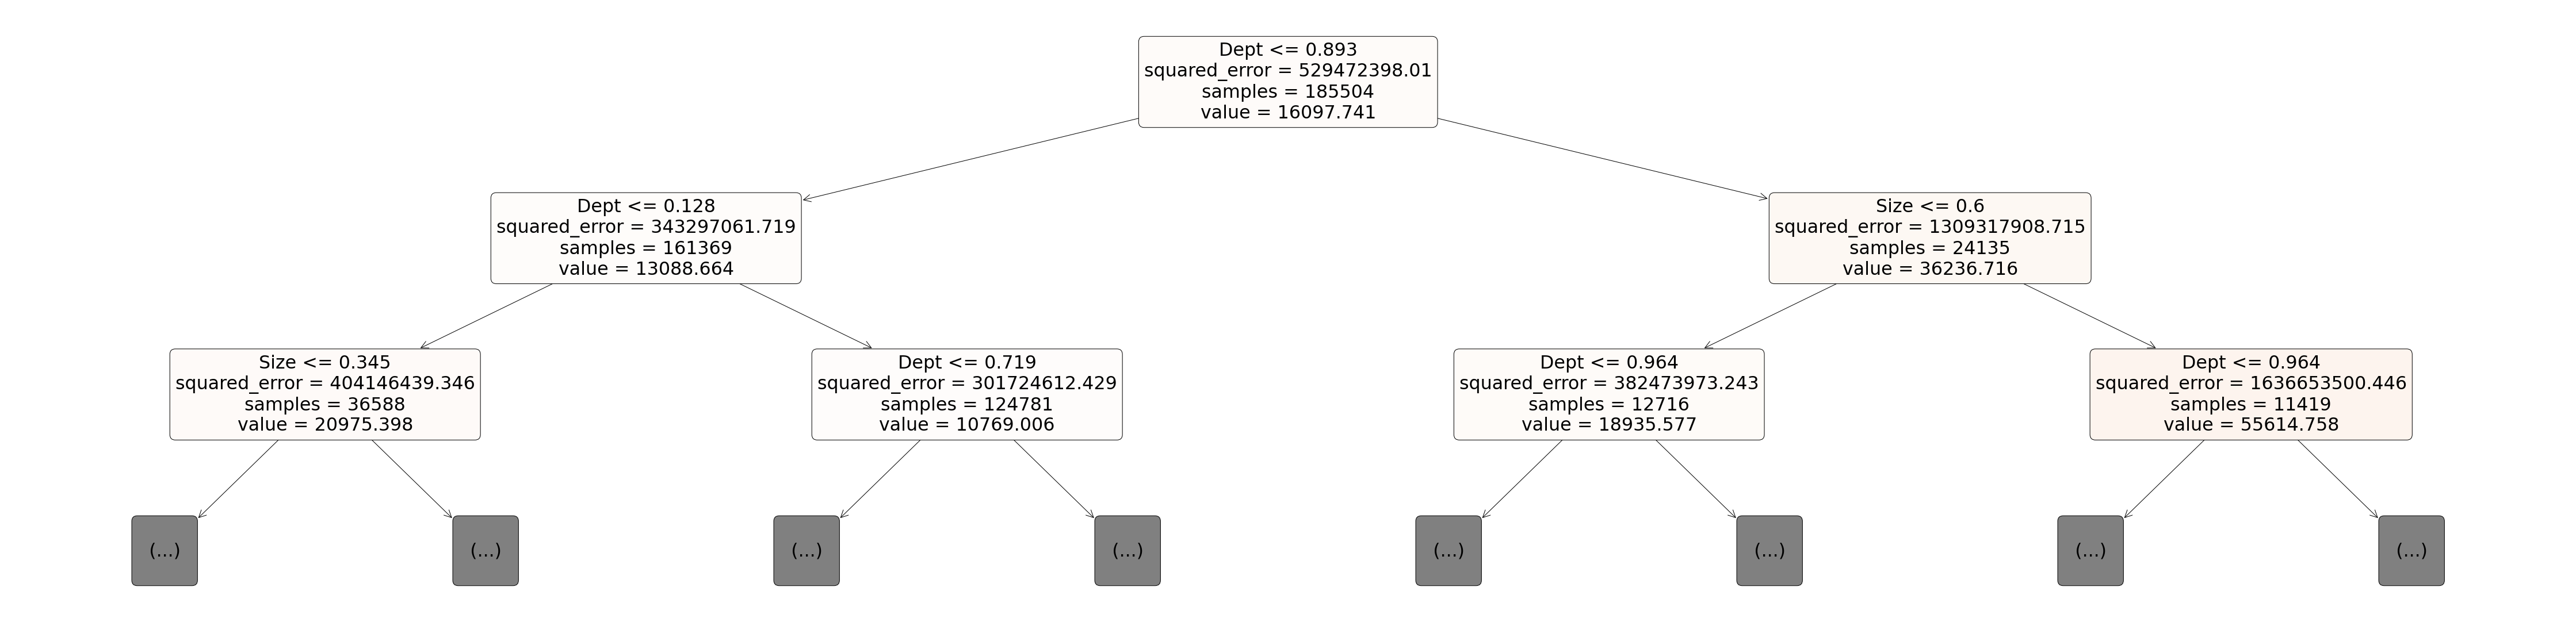

In [ ]:
plt.figure(figsize=(80,20))
plot_tree(model.estimators_[3], max_depth=2, feature_names=X_train.columns, filled=True, rounded=True);

In [ ]:
len(model.estimators_)

100

Just like decision tree, random forests also assign an "importance" to each feature, by combining the importance values from individual trees.

In [ ]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [ ]:
importance_df.head(10)

,feature,importance
1,Dept,0.615860
2,Size,0.188590
0,Store,0.049212
15,WeekOfYear,0.042981
10,CPI,0.030575
11,Unemployment,0.014811
3,Temperature,0.010766
19,Type_B,0.010611
14,Day,0.009523
13,Month,0.006845


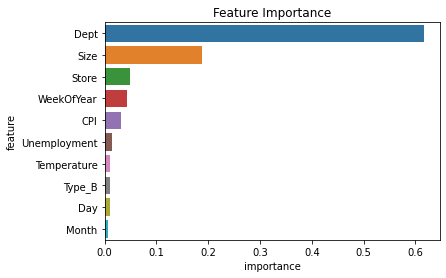

In [ ]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

## Hyperparameter Tuning with Random Forests

Just like decision trees, random forests also have several hyperparameters. In fact many of these hyperparameters are applied to the underlying decision trees. 

Let's study some the hyperparameters for random forests. You can learn more about them here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [ ]:
?RandomForestRegressor

In [ ]:
base_model = RandomForestRegressor(random_state = 42, n_jobs = -1).fit(X_train, train_targets)

In [ ]:
base_train_acc = base_model.score(X_train, train_targets)
base_val_acc = base_model.score(X_val, val_targets)

In [ ]:
base_accs = base_train_acc, base_val_acc
base_accs

(0.9966456662495163, 0.9504815664085803)

We can use this as a benchmark for hyperparmeter tuning. Parameters whose accuracy is indicated above

### `n_estimators`

This argument controls the number of decision trees in the random forest. The default value is 100. For larger datasets, it helps to have a greater number of estimators. As a general rule, try to have as few estimators as needed. 


**10 estimators**

In [ ]:
model = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=10)

In [ ]:
model.fit(X_train, train_targets)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=42)

In [ ]:
model.score(X_train, train_targets), model.score(X_val, val_targets)

(0.9952714380082693, 0.9447101146952863)

In [ ]:
base_accs

(0.9966456662495163, 0.9504815664085803)

### `max_depth` and `max_leaf_nodes`

These arguments are passed directly to each decision tree, and control the maximum depth and max. no leaf nodes of each tree respectively. By default, no maximum depth is specified, which is why each tree has a training accuracy of 100%. You can specify a `max_depth` to reduce overfitting.

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

In [ ]:
def test_params(**params):
    model = RandomForestRegressor(random_state=42, n_jobs=-1, **params).fit(X_train, train_targets)
    return model.score(X_train, train_targets), model.score(X_val, val_targets)

Let's test a few values of `max_depth` and `max_leaf_nodes`.

In [ ]:
test_params(max_depth=5)

(0.5708844218006391, 0.6143671422695467)

In [ ]:
test_params(max_depth=26)

(0.9965656038801788, 0.9505392788139794)

In [ ]:
test_params(max_leaf_nodes=2**5)

(0.6975959201234443, 0.7240825856821022)

In [ ]:
test_params(max_leaf_nodes=2**20)

(0.9966665669000103, 0.9507769621123271)

In [ ]:
base_accs # no max depth or max leaf nodes

(0.9966456662495163, 0.9504815664085803)

The optimal values of `max_depth` and `max_leaf_nodes` lies somewhere between 0 and unbounded.

### Putting it together

Let's train a random forest with customized hyperparameters based on our learnings. Of course, different hyperparams

In [ ]:
model = RandomForestRegressor(n_jobs=-1, 
                               random_state=42)

In [ ]:
%%time
model.fit(X, targets)

CPU times: user 10min 50s, sys: 4.66 s, total: 10min 54s
Wall time: 5min 33s


RandomForestRegressor(n_jobs=-1, random_state=42)

Now that the model is trained, we can make predictions on the test set.

In [ ]:
test_preds_rf = model.predict(X_test)

In [ ]:
test_preds_rf

array([32791.7176, 22046.1734, 18716.2636, ...,   408.822 ,   382.8024,
         395.4766])

Let's add the predictions into `sample_submission_df`.

In [ ]:
sample_submission_df['Weekly_Sales'] = test_preds_rf

In [ ]:
sample_submission_df

,Id,Weekly_Sales
0,1_1_2012-11-02,32791.7176
1,1_1_2012-11-09,22046.1734
2,1_1_2012-11-16,18716.2636
3,1_1_2012-11-23,20111.7339
4,1_1_2012-11-30,24907.9937
...,...,...
115059,45_98_2013-06-28,392.0996
115060,45_98_2013-07-05,423.9806
115061,45_98_2013-07-12,408.8220
115062,45_98_2013-07-19,382.8024


We can now save the predictions as a CSV file.

In [ ]:
sample_submission_df.to_csv('RFsampleSubmission.csv', index = None)

In [ ]:
from IPython.display import FileLink

In [ ]:
FileLink('RFsampleSubmission.csv')

/content/RFsampleSubmission.csv

We've improved the score/error to 3533.45336 (a significant improvement from the Decision Tree), improving our ranking to the 45th percentile. (Position 313/688) on the Kaggle Leaderboard with a well-tuned random forest. Depending on the dataset and the kind of problem, you may or may not a see a significant improvement with hyperparameter tuning. 

This could be due to any of the following reasons:

- We may not have found the right mix of hyperparameters to regularize (reduce overfitting) the model properly, and we should keep trying to improve the model.

- We may have reached the limits of the modeling technique we're currently using (Random Forests), and we should try another modeling technique e.g. gradient boosting.

- We may have reached the limits of what we can predict using the given amount of data, and we may need more data to improve the model.

- We may have reached the limits of how well we can predict whether it will rain tomorrow using the given weather measurements, and we may need more features (columns) to further improve the model. In many cases, we can also generate new features using existing features (this is called feature engineering).

- Whether it will rain tomorrow may be an inherently random or chaotic phenomenon which simply cannot be predicted beyond a certain accuracy any amount of data for any number of weather measurements with any modeling technique.  

Remember that ultimately all models are wrong, but some are useful. If you can rely on the model we've created today to make a travel decision for tomorrow, then the model is useful, even though it may sometimes be wrong.

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/mitchell-odili/walmart-store-sales-forecasting


'https://jovian.ai/mitchell-odili/walmart-store-sales-forecasting'

#### XGBRegressor
To train a GBM, we can use the `XGBRegressor` class from the [`XGBoost`](https://xgboost.readthedocs.io/en/latest/) library.

In [ ]:
from xgboost import XGBRegressor

In [ ]:
model = XGBRegressor(random_state = 42, n_jobs = -1, n_estimators = 20, max_depth = 4)

Let's train the model using `model.fit`.

In [ ]:
model.fit(X, targets)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=20, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Prediction

We can now make predictions and evaluate the model using `model.predict`.

In [ ]:
preds = model.predict(X)

In [ ]:
preds

array([23645.232  , 42381.477  , 16201.863  , ..., 32785.875  ,
        4918.7056 ,   922.57623], dtype=float32)

### Evaluation

Let's evaluate the predictions using RMSE error.

In [ ]:
from sklearn.metrics import mean_squared_error

def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

In [ ]:
rmse(preds, targets)

10794.514467476942

### Visualization

We can visualize individual trees using `plot_tree` (note: this requires the `graphviz` library to be installed).

In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_tree
from matplotlib.pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = 30,30

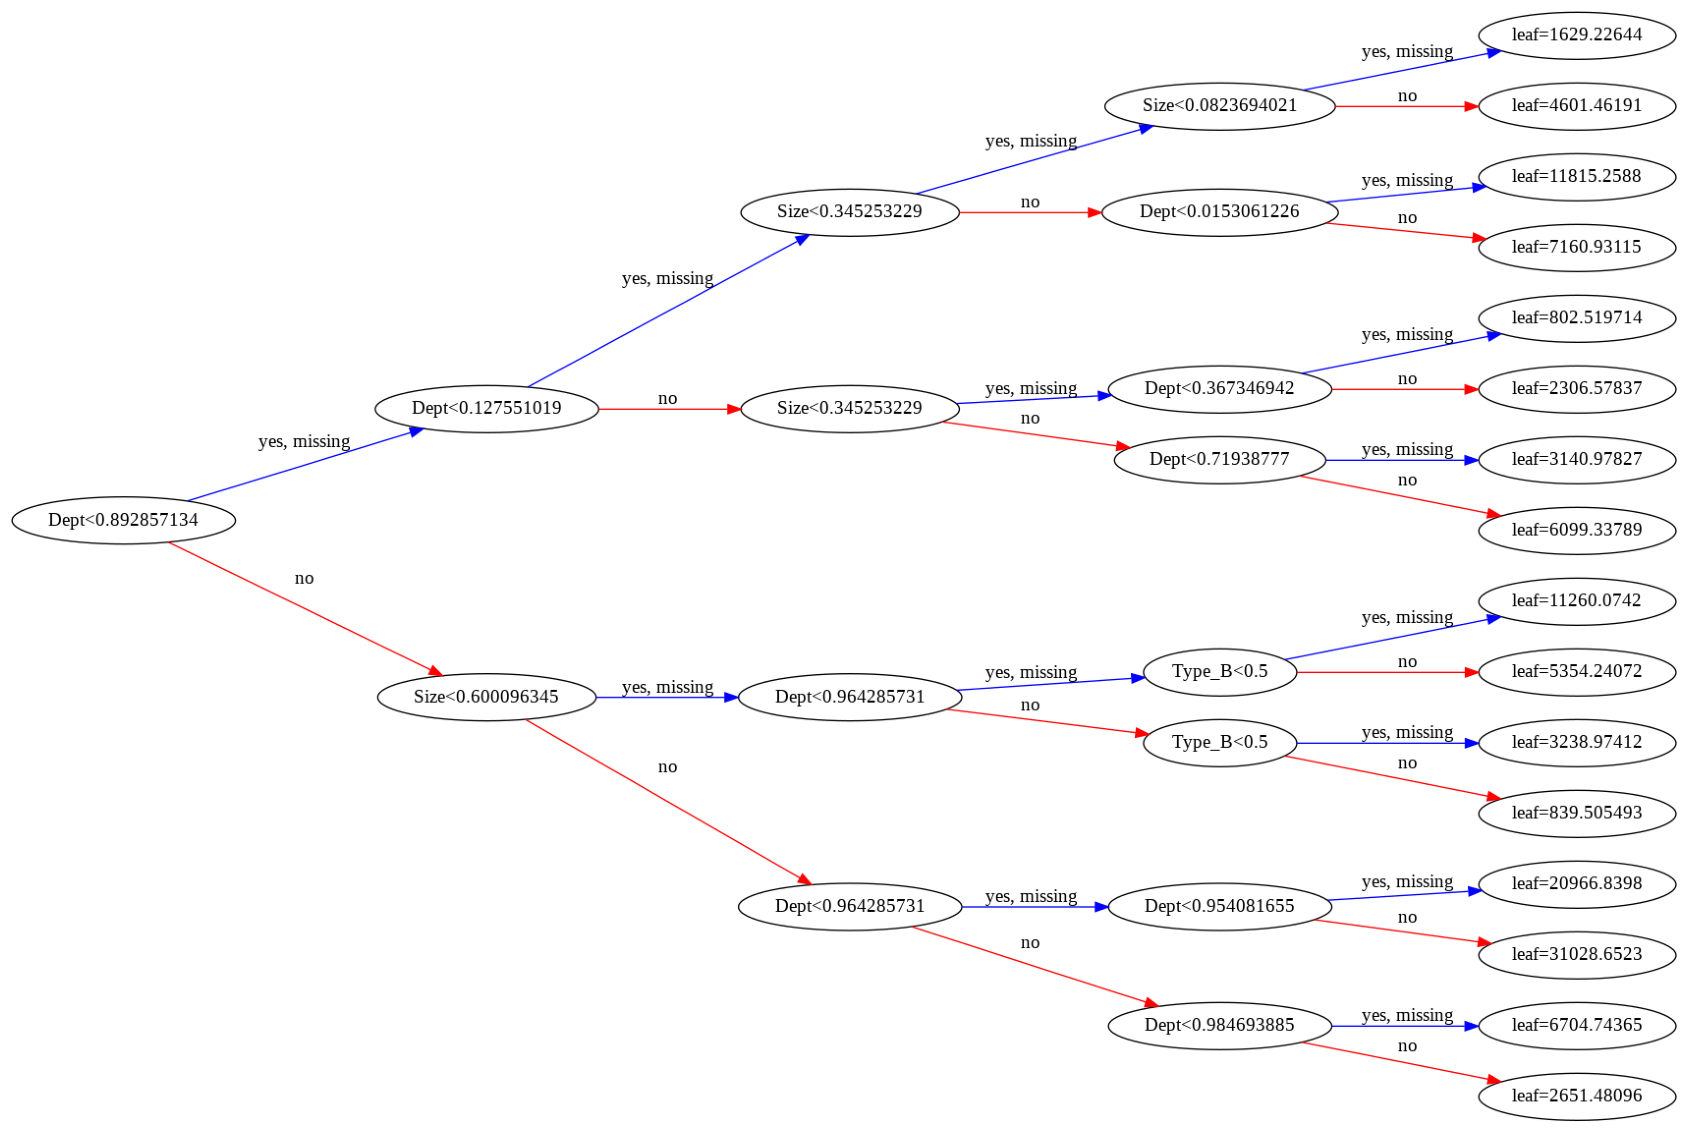

In [ ]:
plot_tree(model, rankdir='LR');

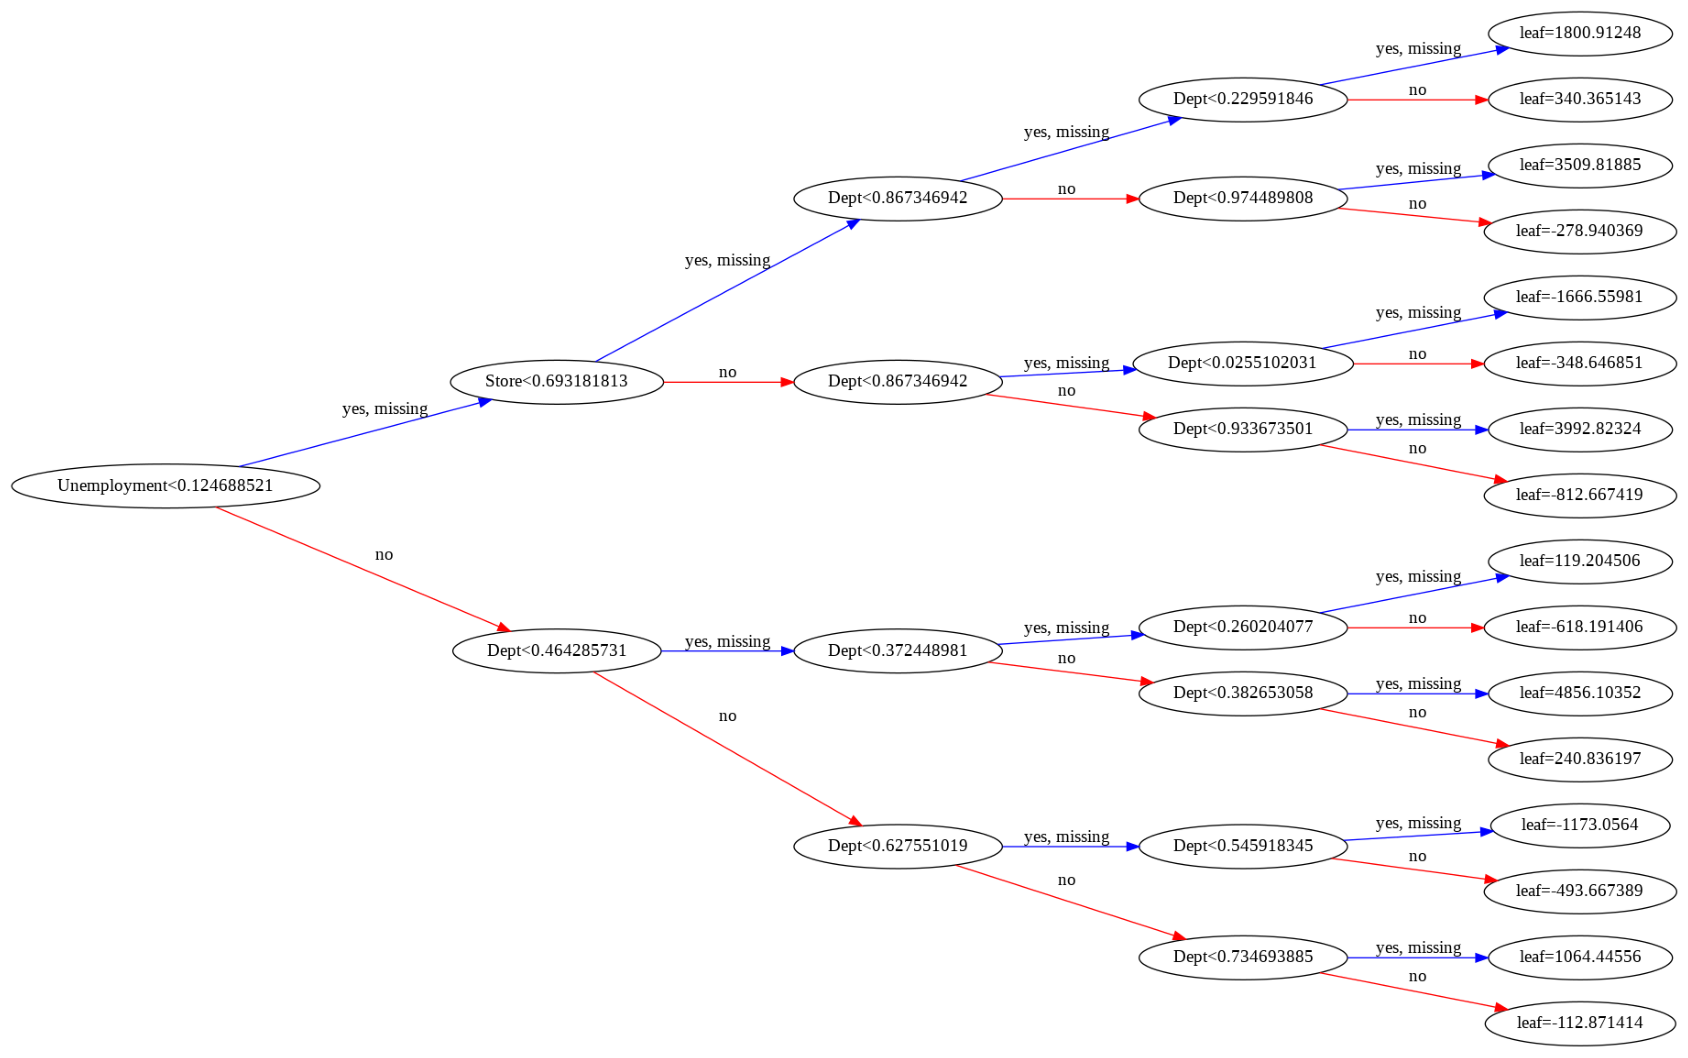

In [ ]:
plot_tree(model, rankdir='LR', num_trees=19);

Notice how the trees only compute residuals, and not the actual target value. We can also visualize the tree as text.

In [ ]:
trees = model.get_booster().get_dump()

In [ ]:
len(trees)

20

In [ ]:
print(trees[0])

0:[Dept<0.892857134] yes=1,no=2,missing=1
	1:[Dept<0.127551019] yes=3,no=4,missing=3
		3:[Size<0.345253229] yes=7,no=8,missing=7
			7:[Size<0.0823694021] yes=15,no=16,missing=15
				15:leaf=1629.22644
				16:leaf=4601.46191
			8:[Dept<0.0153061226] yes=17,no=18,missing=17
				17:leaf=11815.2588
				18:leaf=7160.93115
		4:[Size<0.345253229] yes=9,no=10,missing=9
			9:[Dept<0.367346942] yes=19,no=20,missing=19
				19:leaf=802.519714
				20:leaf=2306.57837
			10:[Dept<0.71938777] yes=21,no=22,missing=21
				21:leaf=3140.97827
				22:leaf=6099.33789
	2:[Size<0.600096345] yes=5,no=6,missing=5
		5:[Dept<0.964285731] yes=11,no=12,missing=11
			11:[Type_B<0.5] yes=23,no=24,missing=23
				23:leaf=11260.0742
				24:leaf=5354.24072
			12:[Type_B<0.5] yes=25,no=26,missing=25
				25:leaf=3238.97412
				26:leaf=839.505493
		6:[Dept<0.964285731] yes=13,no=14,missing=13
			13:[Dept<0.954081655] yes=27,no=28,missing=27
				27:leaf=20966.8398
				28:leaf=31028.6523
			14:[Dept<0.984693885] yes=29,no=30,

### Feature importance

Just like decision trees and random forests, XGBoost also provides a feature importance score for each column in the input.

In [ ]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [ ]:
importance_df.head(10)

,feature,importance
1,Dept,0.249013
2,Size,0.213528
7,MarkDown3,0.156463
19,Type_B,0.099339
0,Store,0.060020
10,CPI,0.057170
15,WeekOfYear,0.056116
20,Type_C,0.048159
11,Unemployment,0.031608
14,Day,0.019308


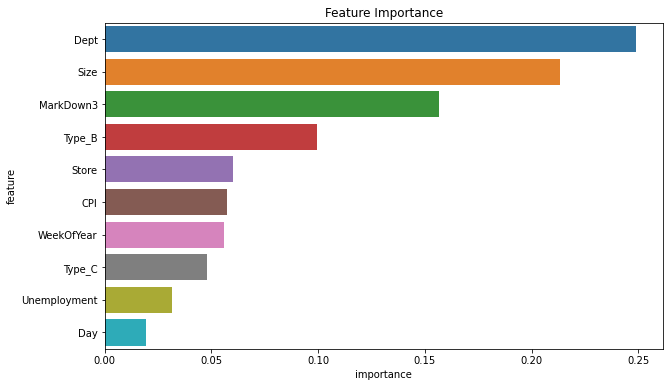

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

Let's define a helper function `train_and_evaluate` which trains a model the given parameters and returns the trained model, training error and validation error.

In [ ]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    return model, train_rmse, val_rmse

## Hyperparameter Tuning and Regularization

Just like other machine learning models, there are several hyperparameters we can to adjust the capacity of model and reduce overfitting.

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

Check out the following resources to learn more about hyperparameter supported by XGBoost:

- https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://xgboost.readthedocs.io/en/latest/parameter.html

In [ ]:
def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

#### `n_estimators`

The number of trees to be created. More trees = greater capacity of the model.

In [ ]:
test_params(n_estimators=10)

Train RMSE: 9975.395520074368, Validation RMSE: 9249.354493980869


In [ ]:
test_params(n_estimators=30)

Train RMSE: 7176.298848411599, Validation RMSE: 7060.735981386138


In [ ]:
test_params(n_estimators=100)

Train RMSE: 5159.984736430045, Validation RMSE: 5751.826582205885


In [ ]:
test_params(n_estimators=200)

Train RMSE: 4225.690628027311, Validation RMSE: 5428.722964814552


#### `max_depth`

As you increase the max depth of each tree, the capacity of the tree increases and it can capture more information about the training set.

In [ ]:
test_params(max_depth=2)

Train RMSE: 12287.072981082709, Validation RMSE: 10677.820227758315


In [ ]:
test_params(max_depth=5)

Train RMSE: 6602.753143595063, Validation RMSE: 6571.439378603924


In [ ]:
test_params(max_depth=10)

Train RMSE: 2106.005452705437, Validation RMSE: 4968.294035417425


#### `learning_rate`

The scaling factor to be applied to the prediction of each tree. A very high learning rate (close to 1) will lead to overfitting, and a low learning rate (close to 0) will lead to underfitting.

In [ ]:
test_params(n_estimators=50, learning_rate=0.01)

Train RMSE: 19758.697651035855, Validation RMSE: 18836.21345647326


In [ ]:
test_params(n_estimators=50, learning_rate=0.1)

Train RMSE: 8614.304028895971, Validation RMSE: 7963.361969846839


In [ ]:
test_params(n_estimators=50, learning_rate=0.3)

Train RMSE: 6249.094703263899, Validation RMSE: 6388.02687528732


In [ ]:
test_params(n_estimators=50, learning_rate=0.9)

Train RMSE: 5203.958928230976, Validation RMSE: 7493.113049069158


#### `booster`

Instead of using Decision Trees, XGBoost can also train a linear model for each iteration. This can be configured using `booster`.

In [ ]:
test_params(booster='gblinear')

Train RMSE: 21925.209256191967, Validation RMSE: 21273.982988596512


Clearly, a linear model is not well suited for this dataset.

## Putting it Together and Making Predictions

Let's train a final model on the entire training set with custom hyperparameters. 

In [ ]:
model = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000, 
                     learning_rate=0.2, max_depth=10, subsample=0.9, 
                     colsample_bytree=0.7)

In [ ]:
%%time
model.fit(X, targets)

Now that the model is trained, we can make predictions on the test set.

In [ ]:
test_preds = model.predict(X_test)

Let's add the predictions into `sample_submission_df`.

In [ ]:
test_preds

In [ ]:
sample_submission_df['Weekly_Sales'] = test_preds

In [ ]:
sample_submission_df

We can now save the predictions as a CSV file.

In [ ]:
sample_submission_df.to_csv('XGBsampleSubmission.csv', index = None)

In [ ]:
from IPython.display import FileLink

In [ ]:
FileLink('XGBsampleSubmission.csv')

The resultant score/error on Kaggle's Leaderboard is 4053.56097 (position 365/688) worse off than the Random Forest Regressor under the given parameters for this model. The random Forest is the best Machine Learning algorithm to use for this model

In [ ]:
jovian.commit()

## Summary and References

The following topics were covered in this tutorial:

- Downloading a real-world dataset
- Preparing a dataset for training
- Training and interpreting decision trees
- Training and interpreting random forests
- Training and interpreting xgboost 
- Overfitting, hyperparameter tuning & regularization
- Making predictions on single inputs



We also introduced the following terms:

* Decision tree
* Random forest
* Overfitting
* Hyperparameter
* Hyperparameter tuning
* Regularization
* Ensembling
* Generalization
* Bootstrapping


Check out the following resources to learn more: 

- https://scikit-learn.org/stable/modules/tree.html
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
- https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction
- https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering
- https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search
- https://www.kaggle.com/c/home-credit-default-risk/discussion/64821
Learn more:
- https://albertum.medium.com/l1-l2-regularization-in-xgboost-regression-7b2db08a59e0
- https://machinelearningmastery.com/evaluate-gradient-boosting-models-xgboost-python/
- https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://xgboost.readthedocs.io/en/latest/parameter.html
- https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/overview

In [ ]:
jovian.commit()